<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Нам нужно:**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных:**
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Ход исследования:**
1. Загрузка и предобработка данных. Загрузим данные и выполним их ресемплирование по одному часу.
2. Анализ данных. Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.
3. Обучение моделей. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных. Выберем лучшую модель на основе метрики RMSE.
4. Тестирование. Проверим данные на тестовой выборе и сделаем выводы. Учтем, что значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
5. Выводы.

## Подготовка

Выполним загрузку библиотек.

In [1]:
#установим библиотеки
!pip install scikit-learn==1.4.0
!pip install shap 
!pip install phik -q
!pip install missingno

#стандартные библиотеки
import os
import pandas as pd 
import numpy as np
from scipy import stats as st
import time
from time import time

#библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import missingno as msno

import phik

#класс для разделения на выборки
from sklearn.model_selection import train_test_split 

#загружаем классы для подготовки данных
#from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

#загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем класс для работы с пропусками
#from sklearn.impute import SimpleImputer

# загружаем функции для работы с метриками
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.metrics import confusion_matrix

#импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

#from sklearn.model_selection import GridSearchCV

#загружаем модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#функция для анализа временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

#константы
RANDOM_STATE = 42

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм. Установим столбец `datetime` индексом таблицы.

In [2]:
pth1=['/Users/margarita/Desktop/datasets/taxi.csv']
pth2=['/datasets/taxi.csv']

if os.path.exists(pth1[0]):
    taxi_data = pd.read_csv(pth1[0], parse_dates=[0], index_col=[0])
elif os.path.exists(pth2[0]):
    taxi_data = pd.read_csv(pth2[0], parse_dates=[0], index_col=[0])
else:
    print('Something is wrong in taxi')

In [3]:
print('Вывод первых пяти строк датафрейма:\n')
taxi_data.head(5)

Вывод первых пяти строк датафрейма:



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
print('Размер датафрейма:')
taxi_data.shape

Размер датафрейма:


(26496, 1)

In [5]:
print('Общая информация:')
taxi_data.info()

Общая информация:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
print('Проверка на наличие пропусков')
taxi_data.isna().sum()

Проверка на наличие пропусков


num_orders    0
dtype: int64

Выполним проверку хронологичности дат.

In [7]:
print(taxi_data.index.is_monotonic_increasing)

True


Проверим, за какой период представлены данные.

In [8]:
print('В датасете представлена информация за период: с', taxi_data.index.min(), 'по', taxi_data.index.max())

В датасете представлена информация за период: с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


Даты расположены в хронолическом порядке. Далле выполним ресемплирование данных по одному часу.

In [9]:
taxi_data = taxi_data.resample('1H').sum()

**Выводы:**
- Была выполнена загрузка данных. В данных содержится 26496 записей о времени и количестве заказов `num_orders`. Пропуски в данных отсутствуют. Время было установлено индексом таблицы. Данные расположены в хронологическом порядке. В датасете представлена информация за период: с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.
- Далее было выполнено ресемплирование данных по одному часу.

## Анализ

In [10]:
#вывод описательных статистик
taxi_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Используем функцию `seasonal_decomposed`, которая разложит временной ряд на 3 составляющие: тренд, сезонность и остаток. Далее построим графики.

In [11]:
decomposed = seasonal_decompose(taxi_data)

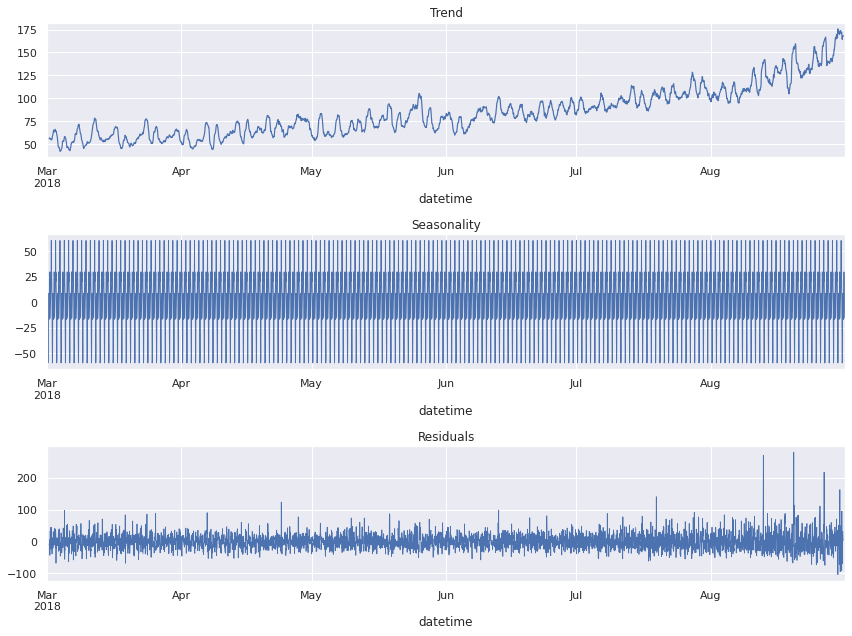

In [12]:
sns.set()

plt.figure(figsize=(12,9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), linewidth=1.2)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), linewidth=0.9)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), linewidth=0.8)
plt.title('Residuals')
plt.tight_layout()

Визуализируем сезонность на более коротком интервале.

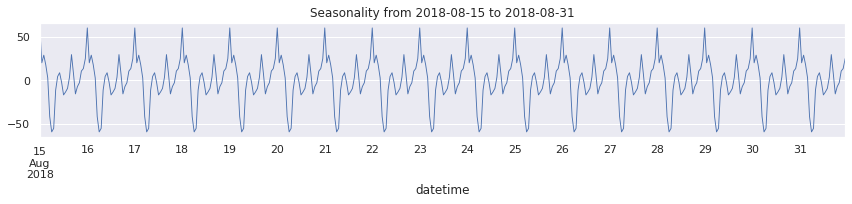

In [13]:
plt.figure(figsize=(12,3))
decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca(), linewidth=0.9)
plt.title('Seasonality from 2018-08-15 to 2018-08-31')
plt.tight_layout()

Рассмотрим скользящее стандартное отклонение и среднее. `Size of the moving window` зададим в размере 24 (24 часа = 1 сутки).

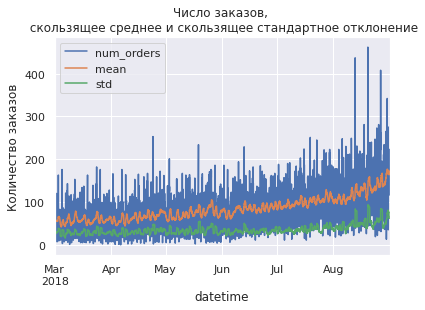

In [14]:
taxi_mean_std = taxi_data
taxi_mean_std['mean'] = taxi_mean_std['num_orders'].rolling(24).mean()
taxi_mean_std['std'] = taxi_mean_std['num_orders'].rolling(24).std()
taxi_mean_std.plot(title='Число заказов, \n скользящее среднее и скользящее стандартное отклонение', 
          ylabel='Количество заказов')
plt.show()

Вычислим разности временного ряда. Для них также определим скользящее среднее и скользящее стандартное отклонение.

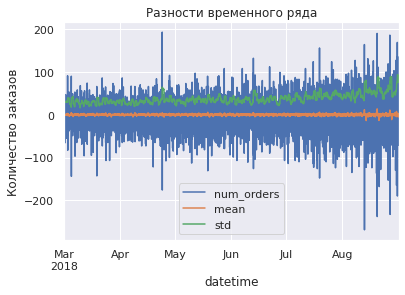

In [15]:
taxi_shift_mean_std = taxi_data - taxi_data.shift()
taxi_shift_mean_std['std'] = taxi_shift_mean_std['num_orders'].rolling(24).std()
taxi_shift_mean_std.plot(title='Разности временного ряда', 
          ylabel='Количество заказов')
plt.show()

**Выводы:**
- С помощью функции `seasonal_decomposed` было выполнено разложение временного ряда на 3 составляющие: тренд, сезонность и остаток. Были построены их графики. Данные представлены за период с марта по август включительно.
- Количество заказов в час изменяется от 0 до 462. При этом среднее число заказов за указанный период составляет 84.
- Cреднее значение количества заказов в целом возрастает от месяца к месяцу. Так, в марте число заказов за час не достигает 100, в то время как в августе доходит до 462 заказов в час. В течение каждого месяца наблюдаются пики и спады активности, похоже, связанные с днями недели. Циклические изменения данных, которые повторяются с постоянным интервалом времени, составляют примерно 55 заказов.
- Установлено, что временной ряд является нестационарным, так как меняется его среднее значение и стандартное отклонение. При этом разности временного ряда более стационарны, чем сам ряд.

## Обучение

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных. Выберем лучшую модель на основе метрики RMSE.

In [16]:
taxi_data = taxi_data.drop(columns=['mean', 'std'], axis=1)
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выполним добавление признаков с помощью функции.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    data_new['day'] = data_new.index.day
    data_new['month'] = data_new.index.month
    
    for lag in range(1, max_lag):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
        
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

Применим функцию к датасету. Параметр max_lag зададим равным 24 часам при создании новых признаков функцией, так как самая очевидная сезонность - внутри суток.

In [18]:
taxi = make_features(taxi_data, 24, 2)
taxi.head(3)

,num_orders,dayofweek,hour,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.5


Разделим данные на обучающую и тестовую выборки.

In [19]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

#удалим строки с пропусками
train = train.dropna()

X_train = train.drop(columns=['num_orders'], axis=1)
X_test = test.drop(columns=['num_orders'], axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

Создадим функцию для расчета метрики качества модели.

In [20]:
#создадим функцию для расчета метрики RMSE
def rmse_score(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

scorer = make_scorer(rmse_score, greater_is_better=False)

Учтем, что все признаки являются числовыми.
Cоздадим пайплайн, в котором будут перебираться четыре варианта масштабирования: методы StandardScaler(), MinMaxScaler(), RobustScaler() и вариант без масштабирования.
Далее запустим итоговый пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. Модели, которые будут рассмотрены: LinearRegression(), LassoRegression(), Ridge(), CatBoostRegressor(), LGBMRegressor(), DecisionTreeRegressor(), SVR().

In [21]:
num_columns = ['dayofweek', 'hour', 'day', 'month',
               'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_mean']

In [22]:
#cоздадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#cоздадим итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [23]:
#cоздадим пайплайн, 
#в котором будут перебираться четыре варианта масштабирования: 
#методы StandardScaler(), MinMaxScaler(), RobustScaler() и вариант без масштабирования
#запустим итоговый пайплайн, который выберет лучшую комбинацию модели и гиперпараметров

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LassoRegression 
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__max_iter': [500, 1000, 2000],
        'models__alpha': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели RidgeRegression()
    {
        'models': [Ridge()],
        'models__alpha': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, iterations=40)],
        'models__simple_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
        'models__combinations_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
        'models__max_depth': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves':range(4, 20),
        'models__max_depth': range(4, 20),
        'models__n_estimators': range(25, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_split': range(1, 10),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [24]:
#выполним обучение модели
%time

randomized_search.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['dayofweek',
                                                                                'hour',
                                                                                'day',
                                                                                'month',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'rolling_mean'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=...
                                         'models__min_samples_split': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVR()],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [25]:
print('Лучшая модель:', randomized_search.best_estimator_)
print('Лучшие гиперпараметры модели:', randomized_search.best_params_)
print ('Метрика RMSE лучшей модели при кросс-валидации:', abs(randomized_search.best_score_.round(2)))

rmse_train = abs(randomized_search.best_score_.round(2))

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['dayofweek', 'hour', 'day',
                                                   'month', 'lag_1', 'lag_2',
                                                   'lag_3', 'lag_4', 'lag_5',
                                                   'rolling_mean'])])),
                ('models',
                 LGBMRegressor(max_depth=17, n_estimators=42, num_leaves=17,
                               random_state=42))])
Лучшие гиперпараметры модели: {'preprocessor__num': RobustScaler(), 'models__num_leaves': 17, 'models__n_estimators': 42, 'models__max_depth': 17, 'models': LGBMRegressor(random_state=42)}
Метрика RMSE лучшей модели при кросс-валидации: 25.35


**Вывод:**
- В датасет были добавлены признаки с помощью функции. Тестовая выборка составляла 10% от исходных данных. 
- Все добавленные признаки являются числовыми. Был создан пайплайн, в котором будут перебираются четыре варианта масштабирования признаков: методы StandardScaler(), MinMaxScaler(), RobustScaler() и вариант без масштабирования.
- Были обучены различные модели с различными гиперпараметрами для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки: LinearRegression(), LassoRegression(), Ridge(), CatBoostRegressor(), LGBMRegressor(), DecisionTreeRegressor(), RandomForestRegressor().
- С помощью итогового пайплайна на основе метрики RMSE была выбрана лучшая комбинация модели и гиперпараметров: LGBMRegressor(max_depth=17, n_estimators=42, num_leaves=17, random_state=42).
- Метрика RMSE лучшей модели при кросс-валидации: 25.35.

## Тестирование

Проверим работу модели на тестовой выборке. Рассчитаем прогноз на тестовых данных. Учтем, что значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [26]:
#проверим работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {abs(root_mean_squared_error(y_test, y_test_pred).round(2))}')

Метрика RMSE на тестовой выборке: 44.28


Визуализируем результат. В начале объединим данные в одну таблицу.

In [27]:
y_test = pd.DataFrame(y_test)
y_test.head()

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104


In [28]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['num_orders_pred'])
y_test_pred.head()

,num_orders_pred
0,101.579724
1,112.892560
2,127.114227
3,129.315016
4,106.185829


In [29]:
y_test_real_pred = pd.concat([y_test.reset_index(), y_test_pred], axis=1).set_index('datetime')
y_test_real_pred.head()

,num_orders,num_orders_pred
datetime,,
2018-08-13 14:00:00,102,101.579724
2018-08-13 15:00:00,175,112.892560
2018-08-13 16:00:00,144,127.114227
2018-08-13 17:00:00,152,129.315016
2018-08-13 18:00:00,104,106.185829


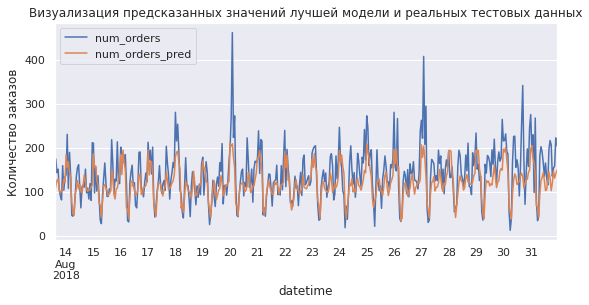

In [30]:
y_test_real_pred.plot(title='Визуализация предсказанных значений лучшей модели и реальных тестовых данных', 
          ylabel='Количество заказов', figsize=(9,4))
plt.show()

**Вывод:**
- Работа лучшей модели была проверена на тестовых данных, был рассчитан прогноз на тестовых данных. 
- Метрика RMSE на тестовой выборке: 44.28

## Выводы

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Была построена модель для такого предсказания.

**Основные выводы:**
1. Подготовка данных.
   - Была выполнена загрузка данных. В данных содержится 26496 записей о времени и количестве заказов `num_orders`. Пропуски в данных отсутствуют. Время было установлено индексом таблицы. Данные расположены в хронологическом порядке. В датасете представлена информация за период: с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.
   - Далее было выполнено ресемплирование данных по одному часу.
2. Анализ данных.
   - С помощью функции `seasonal_decomposed` было выполнено разложение временного ряда на 3 составляющие: тренд, сезонность и остаток. Были построены их графики. Данные представлены за период с марта по август включительно.
   - Количество заказов в час изменяется от 0 до 462. При этом среднее число заказов за указанный период составляет 84.
   - Cреднее значение количества заказов в целом возрастает от месяца к месяцу. Так, в марте число заказов за час не достигает 100, в то время как в августе доходит до 462 заказов в час. В течение каждого месяца наблюдаются пики и спады активности, похоже, связанные с днями недели. Циклические изменения данных, которые повторяются с постоянным интервалом времени, составляют примерно 55 заказов.
   - Установлено, что временной ряд является нестационарным, так как меняется его среднее значение и стандартное отклонение. При этом разности временного ряда более стационарны, чем сам ряд.
3. Обучение.
   - В датасет были добавлены признаки с помощью функции. Тестовая выборка составляла 10% от исходных данных. 
   - Все добавленные признаки являются числовыми. Был создан пайплайн, в котором будут перебираются четыре варианта масштабирования признаков: методы StandardScaler(), MinMaxScaler(), RobustScaler() и вариант без масштабирования.
   - Были обучены различные модели с различными гиперпараметрами для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки: LinearRegression(), LassoRegression(), Ridge(), CatBoostRegressor(), LGBMRegressor(), DecisionTreeRegressor(), SVR().
   - С помощью итогового пайплайна на основе метрики RMSE была выбрана лучшая комбинация модели и гиперпараметров: LGBMRegressor(max_depth=17, n_estimators=42, num_leaves=17, random_state=42).
   - Метрика RMSE лучшей модели при кросс-валидации: 25.35.
4. Тестирование.
   - Работа лучшей модели была проверена на тестовых данных, был рассчитан прогноз на тестовых данных. 
   - Метрика RMSE на тестовой выборке: 44.28